# Curso de Manejo de Datos Faltantes: Imputación

[![Curso creado por jvelezmagic](https://img.shields.io/badge/Desarrollado%20por-%40jvelezmagic-blue?&style=for-the-badge&logo=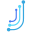)](https://jvelezmagic.com/)

<!-- ![Curso de Manejo de Datos Faltantes: Exploración](course-logo.jpg) -->

## Importar librerías

In [1]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

## Importar funciones personalizadas

In [40]:
%run pandas-missing-extension.ipynb

## Configurar el aspecto general de las gráficas del proyecto

In [3]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (12, 6),
    }
)

sns.set_style("darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

## El problema de trabajar con valores faltantes

In [4]:
airquality_df = (
    sm.datasets.get_rdataset("airquality")
    .data
    .clean_names(
        case_type="snake"
    )
    .add_column("year", 1973)
    .assign(
        date=lambda df: pd.to_datetime(df[["year", "month", "day"]])
    )
    .sort_values(by="date")
    .set_index("date")
)

airquality_df.head()

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973


In [5]:
(
    smf.ols(
        formula="temp ~ ozone",
        data=airquality_df,
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Sun, 12 Mar 2023",Prob (F-statistic):,2.93e-18
Time:,03:40:54,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


In [6]:
(
    smf.ols(
        formula="temp ~ ozone + solar_r",
        data=airquality_df,
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Sun, 12 Mar 2023",Prob (F-statistic):,1.47e-16
Time:,03:40:55,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


### Reto: Datos de supervivientes

In [7]:
survival_df = sm.datasets.get_rdataset("flchain", "survival").data

In [8]:
survival_df.columns

Index(['age', 'sex', 'sample.yr', 'kappa', 'lambda', 'flc.grp', 'creatinine',
       'mgus', 'futime', 'death', 'chapter'],
      dtype='object')

In [9]:
survival_df.isnull().sum()

age              0
sex              0
sample.yr        0
kappa            0
lambda           0
flc.grp          0
creatinine    1350
mgus             0
futime           0
death            0
chapter       5705
dtype: int64

Ajusta algunos modelos utilizando a las variables con valores faltantes como predictoras. ¿Qué sucede?

In [10]:
(
    smf.ols(
        formula='death ~ chapter + age',
        data=survival_df,
    )
    .fit()
    .summary()
    .tables[0]
)

c:\Users\erik1\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\regression\linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Dep. Variable:,death,R-squared:,-inf
Model:,OLS,Adj. R-squared:,-inf
Method:,Least Squares,F-statistic:,-134.5
Date:,"Sun, 12 Mar 2023",Prob (F-statistic):,1.00
Time:,03:41:02,Log-Likelihood:,68460.
No. Observations:,2169,AIC:,-1.369e+05
Df Residuals:,2152,BIC:,-1.368e+05
Df Model:,16,,
Covariance Type:,nonrobust,,


## Preparando datos: _National Health and Nutrition Examination Survey_

c:\Users\erik1\AppData\Local\Programs\Python\Python311\Lib\site-packages\missingno\missingno.py:73: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax0.grid(b=False)
c:\Users\erik1\AppData\Local\Programs\Python\Python311\Lib\site-packages\missingno\missingno.py:142: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=False)


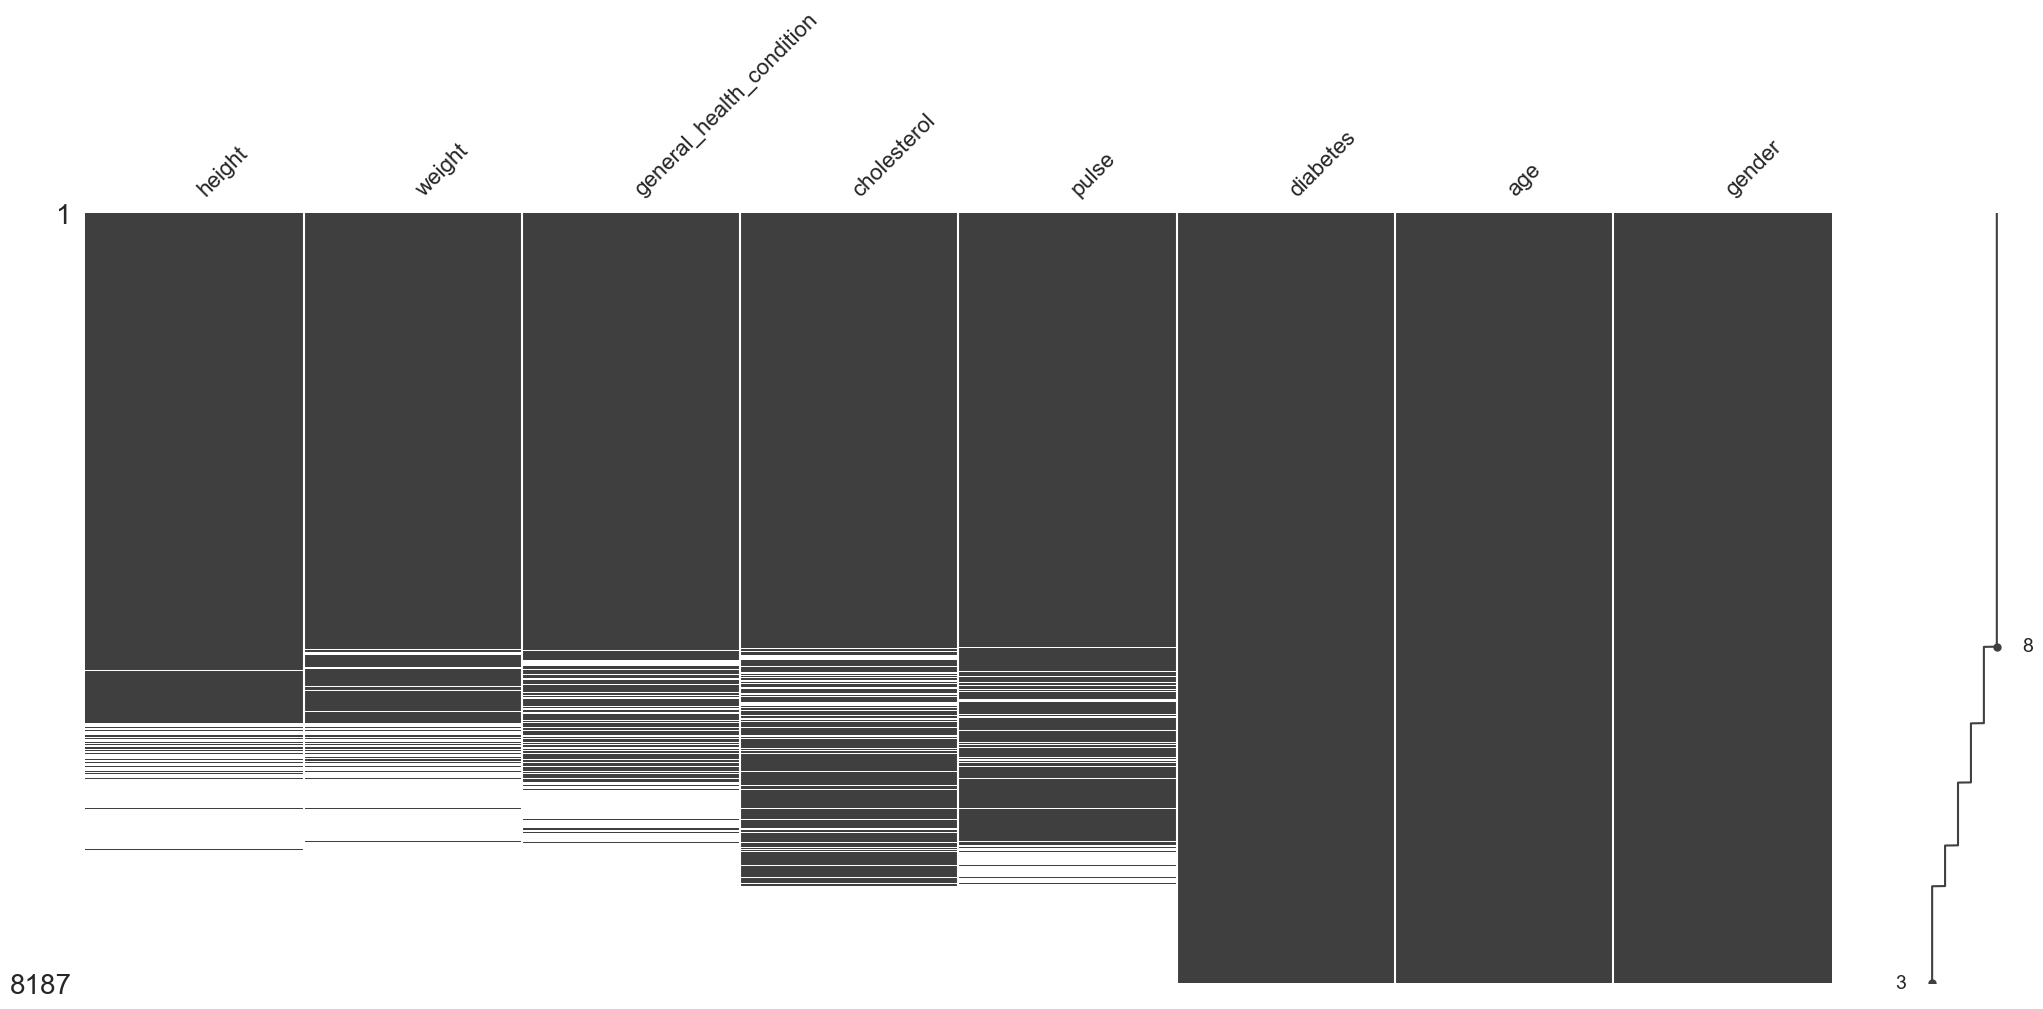

c:\Users\erik1\AppData\Local\Programs\Python\Python311\Lib\site-packages\upsetplot\plotting.py:580: MatplotlibDeprecationWarning: The get_renderer function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.canvas.get_renderer() instead.
  window_extent_args["renderer"] = get_renderer(fig)
c:\Users\erik1\AppData\Local\Programs\Python\Python311\Lib\site-packages\upsetplot\plotting.py:586: MatplotlibDeprecationWarning: The get_renderer function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.canvas.get_renderer() instead.
  window_extent_args["renderer"] = get_renderer(fig)


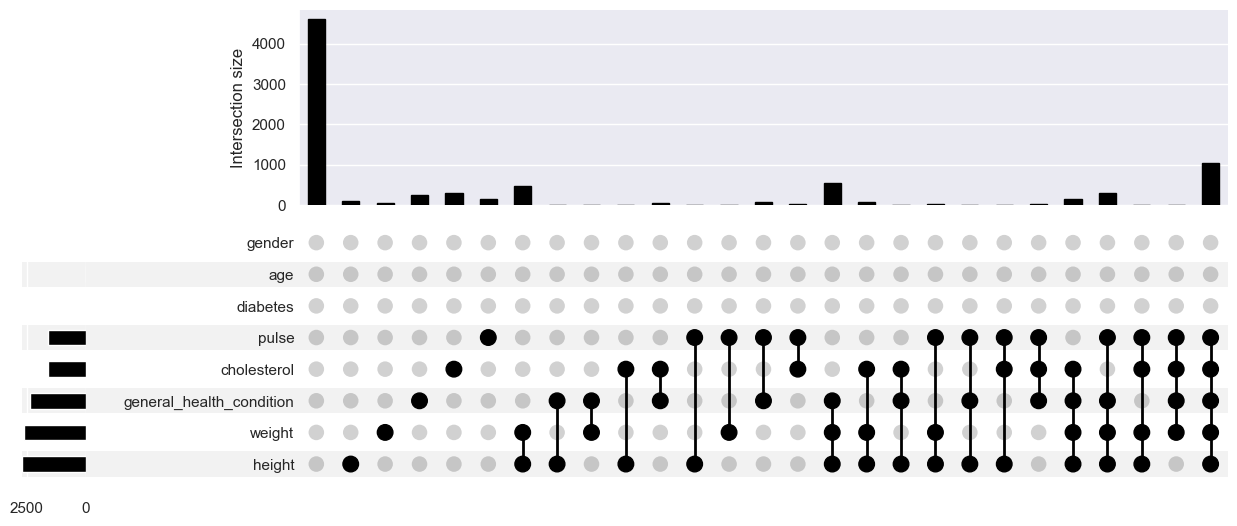

c:\Users\erik1\AppData\Local\Programs\Python\Python311\Lib\site-packages\missingno\missingno.py:73: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax0.grid(b=False)
c:\Users\erik1\AppData\Local\Programs\Python\Python311\Lib\site-packages\missingno\missingno.py:142: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=False)


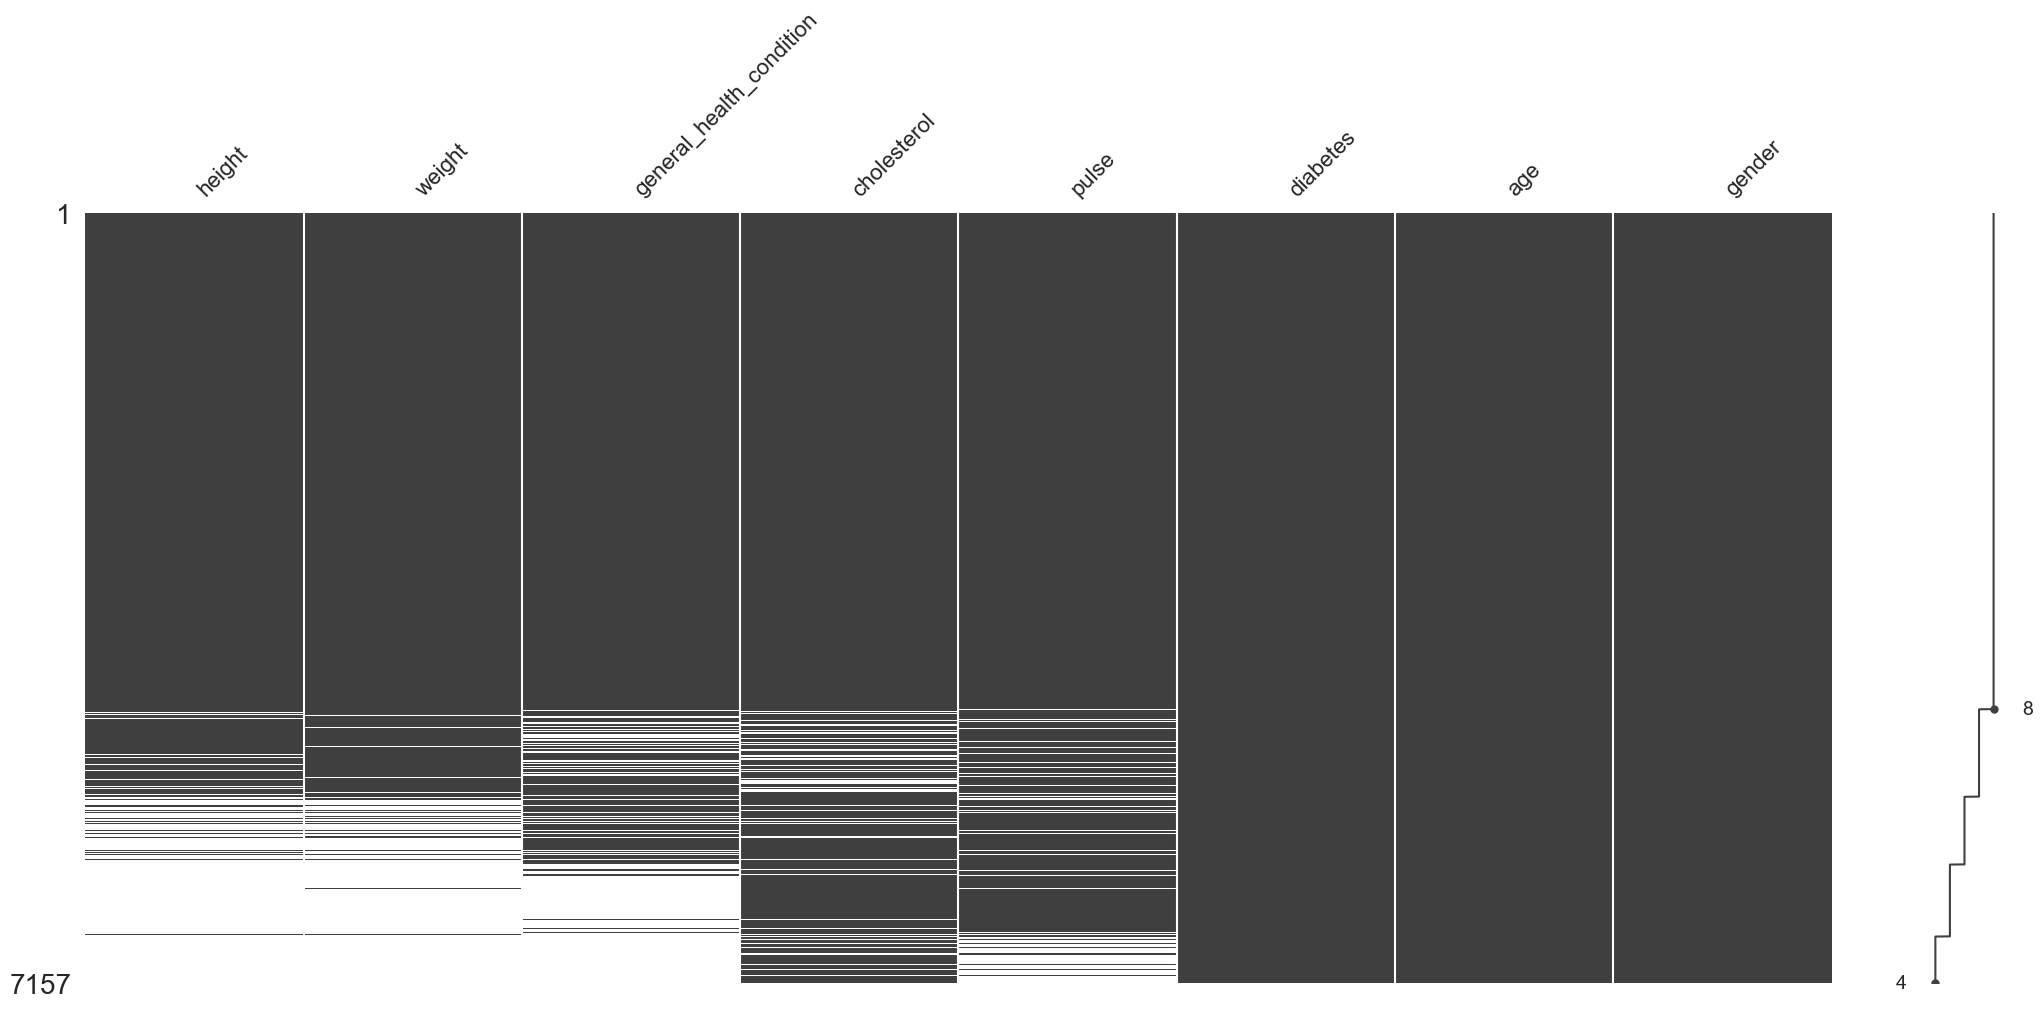

In [11]:
%run download-data-and-load-it.ipynb

## Consideración y evaluación de los distintos tipos de valores faltantes

![](src/img/missing_data_action.jpeg)

## Evaluación del mecanismo de valores faltantes por prueba de _t-test_

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
<code>two-sided</code>: las <b>medias</b> de las distribuciones subyacentes a las muestras son <b>desiguales</b>.<br>
<code>less</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>menor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
<code>greater</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>mayor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
    </p>
</div>

In [12]:
nhanes_df = nhanes_df

In [13]:
famele_weight, male_weight = (
    nhanes_df
    .select_columns('gender', 'weight')
    .transform_column(
        'weight',
        lambda x: x.isnull(),
        elementwise=False # elementwise es para que no se aplique a cada elemento de la columna
    )
    .groupby('gender')
    .weight
    .pipe(
        lambda df: (
            df.get_group('Female'),
            df.get_group('Male')
        )
    )
)

scipy.stats.ttest_ind(
    a = famele_weight,
    b = male_weight,
    alternative='two-sided',
)

Ttest_indResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239)

## Amplía tu conjunto de herramientas para explorar valores faltantes

In [14]:
(
    nhanes_df
    .select_columns('weight', 'general_health_condition', 'gender')
    .assign(
        weight=lambda df: df.weight.isnull().replace([True, False], ['NA', 'Not NA']),
    )
    .groupby(
        ['gender', 'general_health_condition', 'weight'],
        dropna=False,
        as_index=True
    )
    .size()
    .unstack()
)

weight                            NA  Not NA
gender general_health_condition             
Female Excellent                  65     212
       Fair or                    42     549
       Good                      113    1102
       Poor?                       3      94
       Very good                 103     659
       NaN                       489     234
Male   Excellent                  62     273
       Fair or                    31     508
       Good                      112    1056
       Poor?                       2      70
       Very good                  98     643
       NaN                       484     153

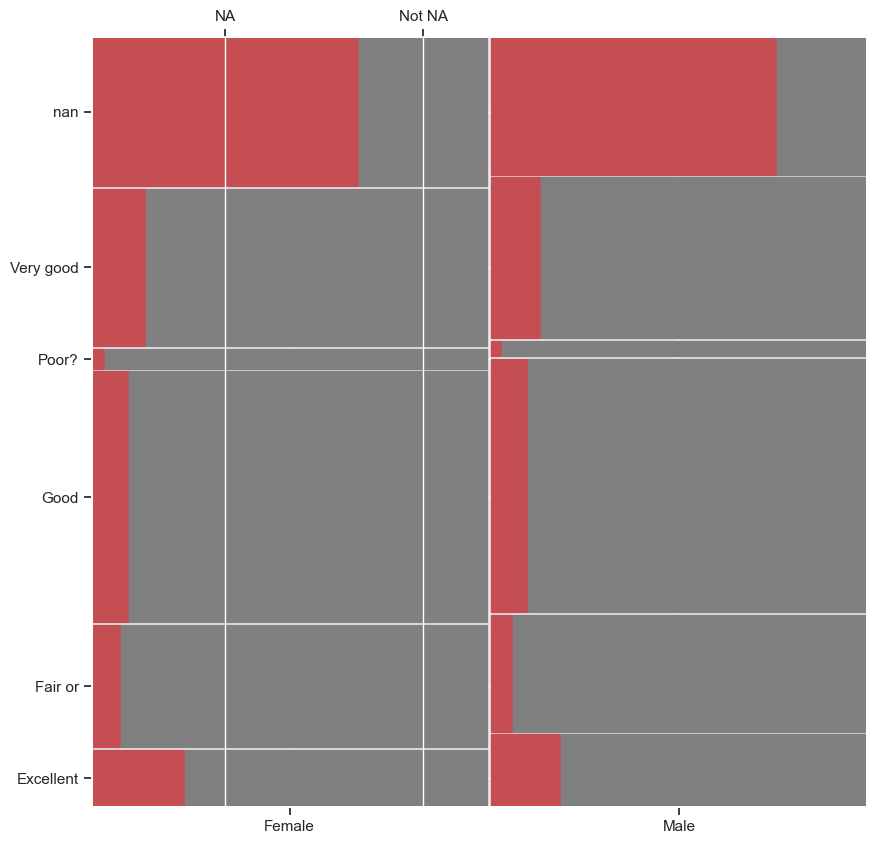

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

(
    nhanes_df
    .select_columns('weight', 'general_health_condition', 'gender')
    .assign(
        weight=lambda df: df.weight.isnull().replace(
            [True, False], ['NA', 'Not NA']),
    )
    .groupby(
        ['gender', 'general_health_condition', 'weight'],
        dropna=False,
        as_index=True
    )
    .size()
    .pipe(
        lambda df: mosaic (
            data = df,
            properties= lambda key: {
                'color': 'r' if 'NA' in key else 'gray'
            },
            horizontal=True,
            axes_label=True,
            title='',
            labelizer=lambda k: '',
            ax=ax
        )
    )
);


In [16]:
nhanes_df.columns

Index(['height', 'weight', 'general_health_condition', 'cholesterol', 'pulse',
       'diabetes', 'age', 'gender'],
      dtype='object')

## Tratamiento de variables categóricas para imputación de valores faltantes

In [17]:
nhanes_transformed_df = nhanes_df.copy(deep=True)

### Codificación ordinal

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
    Una codificación ordinal <b>implica</b> mapear cada etiqueta (categoría) única a un valor entero. A su vez, la codificación ordinal también es conocida como codificación entera.
    </p>
</div>

#### Ejemplo

Dado un conjunto de datos con dos características, encontraremos los valores únicos por cataracterística y los transformaremos utilizando una codificación ordinal.

In [18]:
encoder = sklearn.preprocessing.OrdinalEncoder()
le = sklearn.preprocessing.LabelEncoder()

X = [['Male'], ['Female'], ['Female']]
X

[['Male'], ['Female'], ['Female']]

In [19]:
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

In [20]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [21]:
encoder.inverse_transform([[0], [1], [1]])

array([['Female'],
       ['Male'],
       ['Male']], dtype=object)

#### Aplicando la codificación ordinal a todas tus variables categóricas

In [22]:
categorical_columns = nhanes_df.select_dtypes(include=[object, 'category']).columns
categorical_columns

Index(['general_health_condition', 'gender'], dtype='object')

In [23]:
categorical_transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder='passthrough'  # para que no se transformen las otras columnas
)

In [24]:
categorical_transformer.fit_transform(nhanes_df)

array([[  2.,   0.,  63., ...,  52.,   0.,  66.],
       [  4.,   1.,  68., ...,  82.,   0.,  18.],
       [  2.,   1.,  nan, ..., 100.,   0.,  13.],
       ...,
       [  2.,   0.,  66., ...,  78.,   0.,  41.],
       [  4.,   0.,  nan, ...,  74.,   0.,  14.],
       [  2.,   1.,  69., ...,  76.,   0.,  38.]])

In [25]:
nhanes_transformed_df = (
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df),
        columns=categorical_transformer.get_feature_names_out(),
        index=nhanes_df.index # para que no se pierda el índice (opcional)
    )
    .rename_columns(
        function=lambda x: x.removeprefix('ordinalencoder__')
    )
        .rename_columns(
            function=lambda x: x.removeprefix('remainder__')
    )
)

### _One Hot Encoding_

In [26]:
nhanes_transformed_df2 = nhanes_df.copy(deep=True)

### `pandas.get_dummies()` vs `skelearn.preprocessing.OneHotEncoder()`

#### `pandas.get_dummies()`

In [27]:
(
    nhanes_transformed_df2
    .select_columns('general_health_condition') # Janitor para seleccionar columnas
    # .head(10)
    .pipe(
        pd.get_dummies,
    )
)

,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good
SEQN,,,,,
93705.0,0,0,1,0,0
93706.0,0,0,0,0,1
93707.0,0,0,1,0,0
93709.0,0,0,0,0,0
93711.0,0,0,0,0,1
...,...,...,...,...,...
102949.0,1,0,0,0,0
102953.0,0,1,0,0,0
102954.0,0,0,1,0,0


#### `skelearn.preprocessing.OneHotEncoder()`

In [28]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), ['gender']),
    (sklearn.preprocessing.OneHotEncoder(), ['general_health_condition']),
    remainder='passthrough'
)

In [29]:
nhanes_transformed_df2 = (
    pd.DataFrame(
        transformer.fit_transform(nhanes_df),
        columns=transformer.get_feature_names_out(),
        index=nhanes_df.index # para que no se pierda el índice (opcional)
    )
    .rename_columns(
        function=lambda x: x.removeprefix('ordinalencoder__')
    )
    .rename_columns(
        function=lambda x: x.removeprefix('remainder__')
    )
    .rename_columns(
        function=lambda x: x.removeprefix('onehotencoder__')
    )
)

In [30]:
nhanes_transformed_df2

,gender,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good,general_health_condition_nan,height,weight,cholesterol,pulse,diabetes,age
SEQN,,,,,,,,,,,,,
93705.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [31]:
(
    transformer
    .named_transformers_
    .onehotencoder
    .categories_
)

[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
       dtype=object)]

In [32]:
(
    transformer
    .named_transformers_
    .onehotencoder
    .inverse_transform(
        X = [[0, 0, 1, 0, 0, 0]]
    )
)


array([['Good']], dtype=object)

## Tipos de imputación de valores faltantes

![](src/img/imputation_methods.png)

## Imputación de un único valor (media, mediana, moda)

![](src/img/imputacion-media-mediana-moda.png)

In [33]:
(
    nhanes_df
    # janitor
    .transform_column(
        column_name='height',
        function=lambda x: x.fillna(x.mean()),
        elementwise=False # para que no se aplique a cada elemento de la columna
    )
    .height
    .mean()
)

66.25655976676386

<AxesSubplot: xlabel='height', ylabel='weight'>

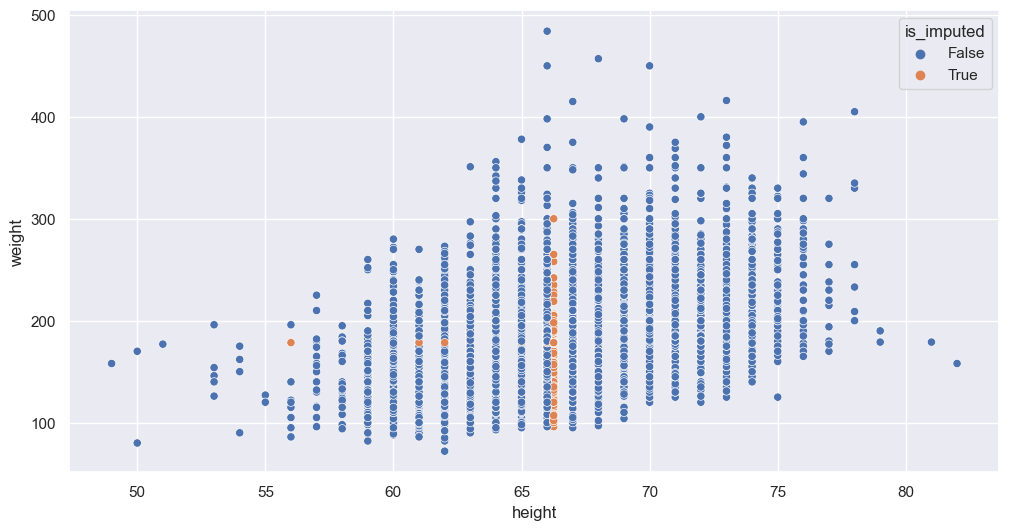

In [42]:
(
    nhanes_df
    .select_columns('height', 'weight') # janitor
    .missing.bind_shadow_matrix(True, False, suffix="_imp")
    .assign(
        height=lambda df: df.height.fillna(df.height.mean()),
        weight=lambda df: df.weight.fillna(df.weight.mean())
    )
    .missing.scatter_imputation_plot(
        x='height',
        y='weight',
    )
)

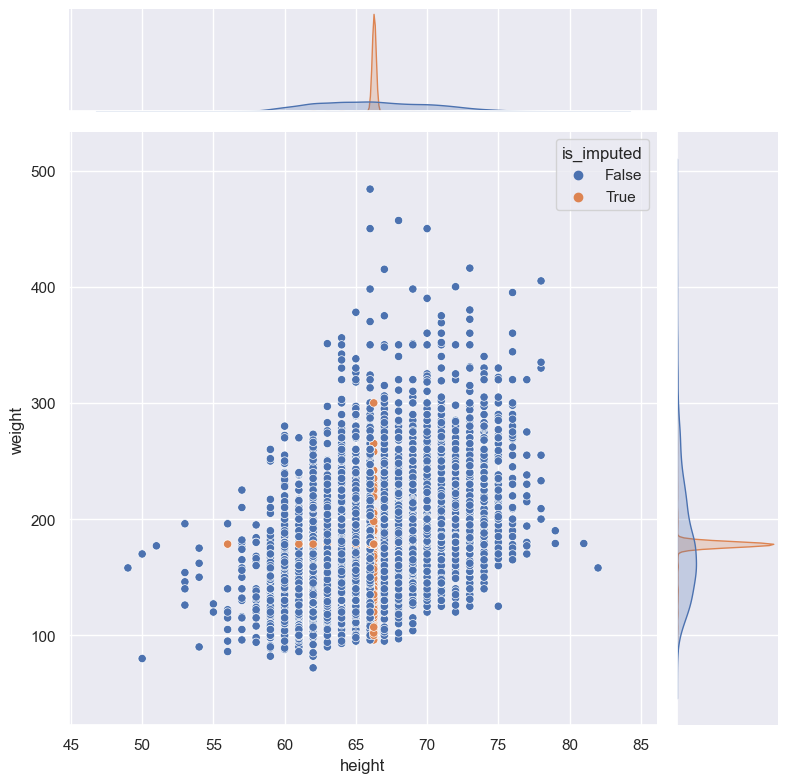

In [85]:
(
    nhanes_df
    .select_columns('height', 'weight') # janitor
    .missing.bind_shadow_matrix(True, False, suffix="_imp")
    .assign(
        height=lambda df: df.height.fillna(df.height.mean()),
        weight=lambda df: df.weight.fillna(df.weight.mean())
    )
    .missing.scatter_imputation_plot(
        x='height',
        y='weight',
        show_marginal = True,
        height=8,
    )
)

## Imputación por llenado hacia atrás e imputación por llenado hacia adelante

!['ventajas y contras'](src/img/imputacion_llenado.png)

### `fillna()` vs `ffill()` o `bfill()`

In [89]:
(
    nhanes_df
    .select_columns('height', 'weight') # janitor
    # .fillna(method='ffill')
    .ffill()
)

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,68.0,145.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


In [90]:
(
    nhanes_df
    .select_columns('height', 'weight') # janitor
    .bfill()
)

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,62.0,200.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


#### Recomendaciones al imputar valores utilizando `ffill()` o `bfill()`

> Imputación dentro de dominios e imputación a través de variables correlacionadas

In [91]:
(
    nhanes_df
    .select_columns('height', 'weight', 'gender', 'general_health_condition', 'diabetes') # janitor
    .sort_values(
        by= ['gender', 'diabetes', 'general_health_condition', 'height'],
        ascending=True # para que sea ascendente (osea de menor a mayor)
    )
    .transform_column(
        column_name='weight',
        function=lambda x: x.ffill(),
        elementwise=False # para que no se aplique a cada elemento de la columna
    ) # janitor
    
)

,height,weight,gender,general_health_condition,diabetes
SEQN,,,,,
94421.0,56.0,115.0,Female,Excellent,0
94187.0,59.0,130.0,Female,Excellent,0
95289.0,59.0,162.0,Female,Excellent,0
97967.0,59.0,130.0,Female,Excellent,0
99125.0,59.0,105.0,Female,Excellent,0
...,...,...,...,...,...
96561.0,74.0,290.0,Male,NaN,1
96954.0,NaN,175.0,Male,NaN,1
97267.0,NaN,175.0,Male,NaN,1


## Imputación por interpolación

!['ventajas y contras'](src/img/imputacion-interpolacion.png)

<AxesSubplot: xlabel='date'>

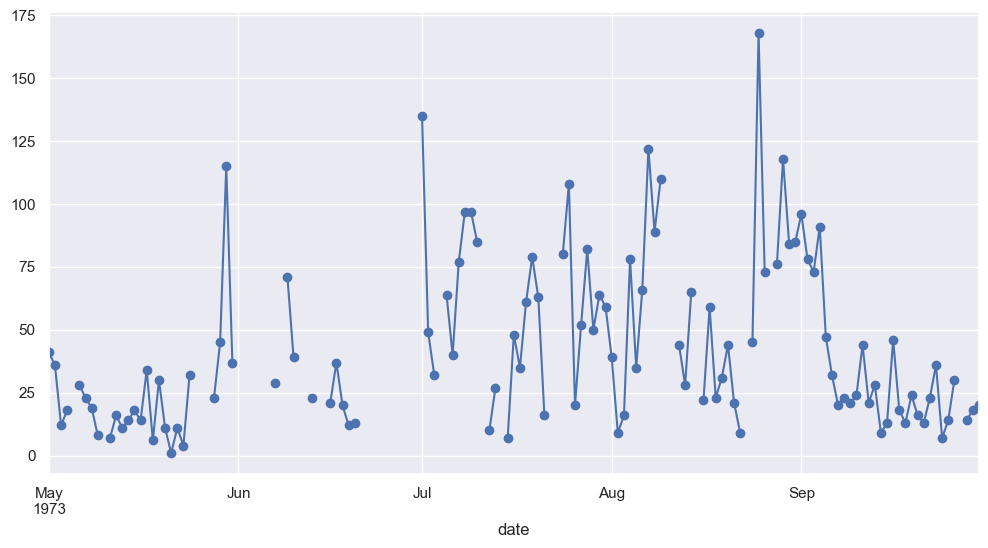

In [100]:
(
    airquality_df
    .pipe(
        lambda df: (
            df.ozone.plot(marker='o')
        )
    )
)

Text(0.5, 1.0, 'Ozone ffilled')

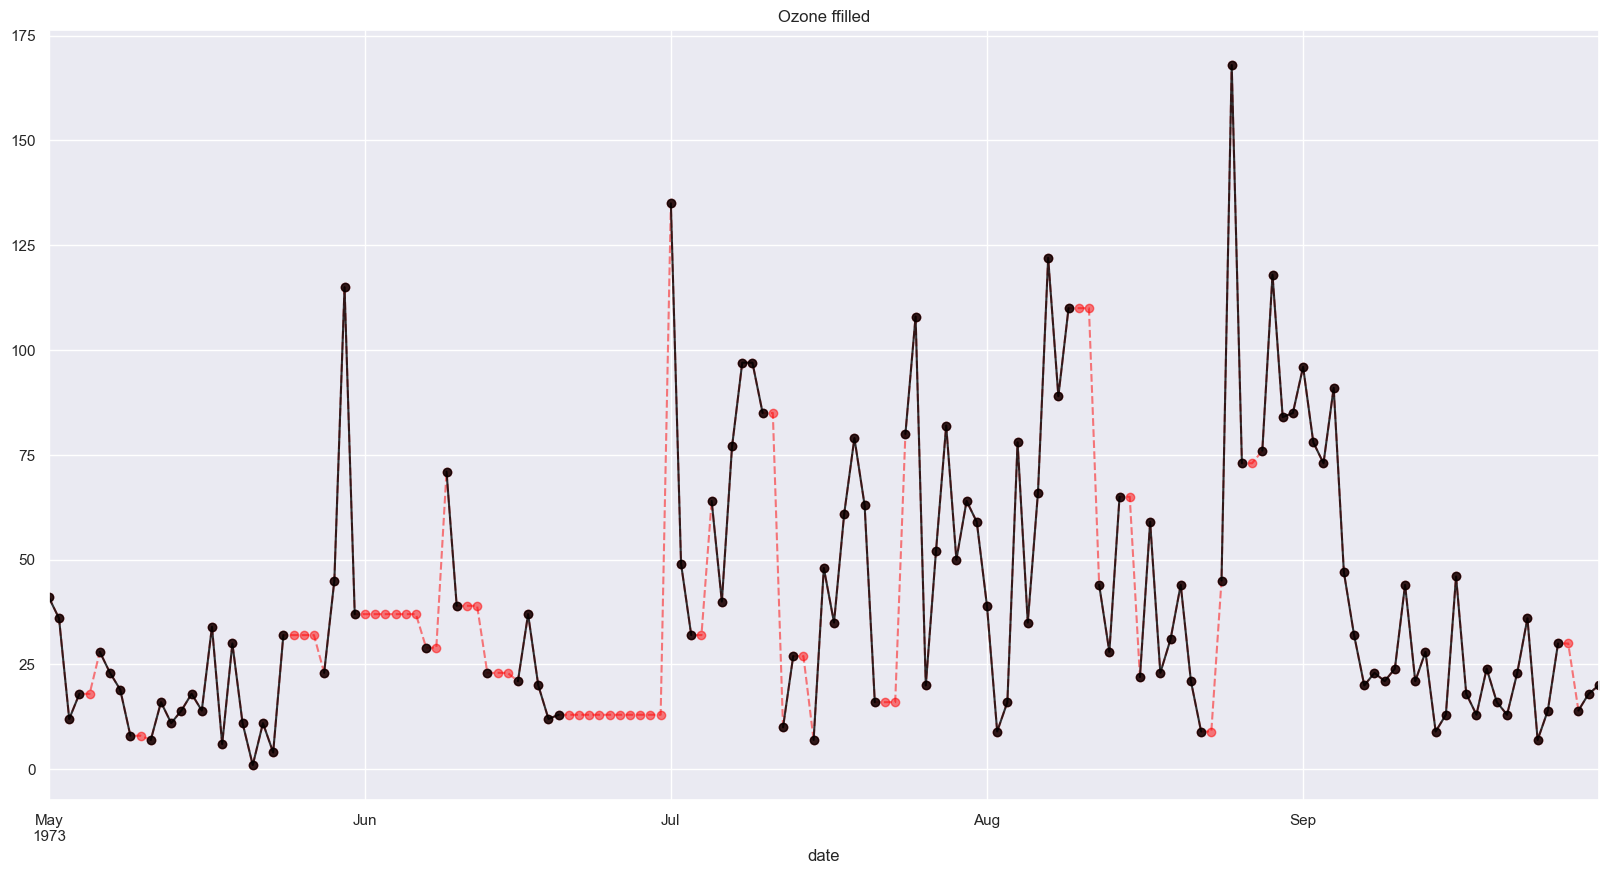

In [115]:
plt.figure(figsize=(20, 10))

(
    airquality_df
    .pipe(
        lambda df: (
            df.ozone.ffill().plot(marker='o', color='red', linestyle='--', alpha=0.5),
            df.ozone.plot(marker='o', alpha=.8, color='black')
        )
    )
)

plt.title('Ozone ffilled')


Text(0.5, 1.0, 'Ozone bfilled')

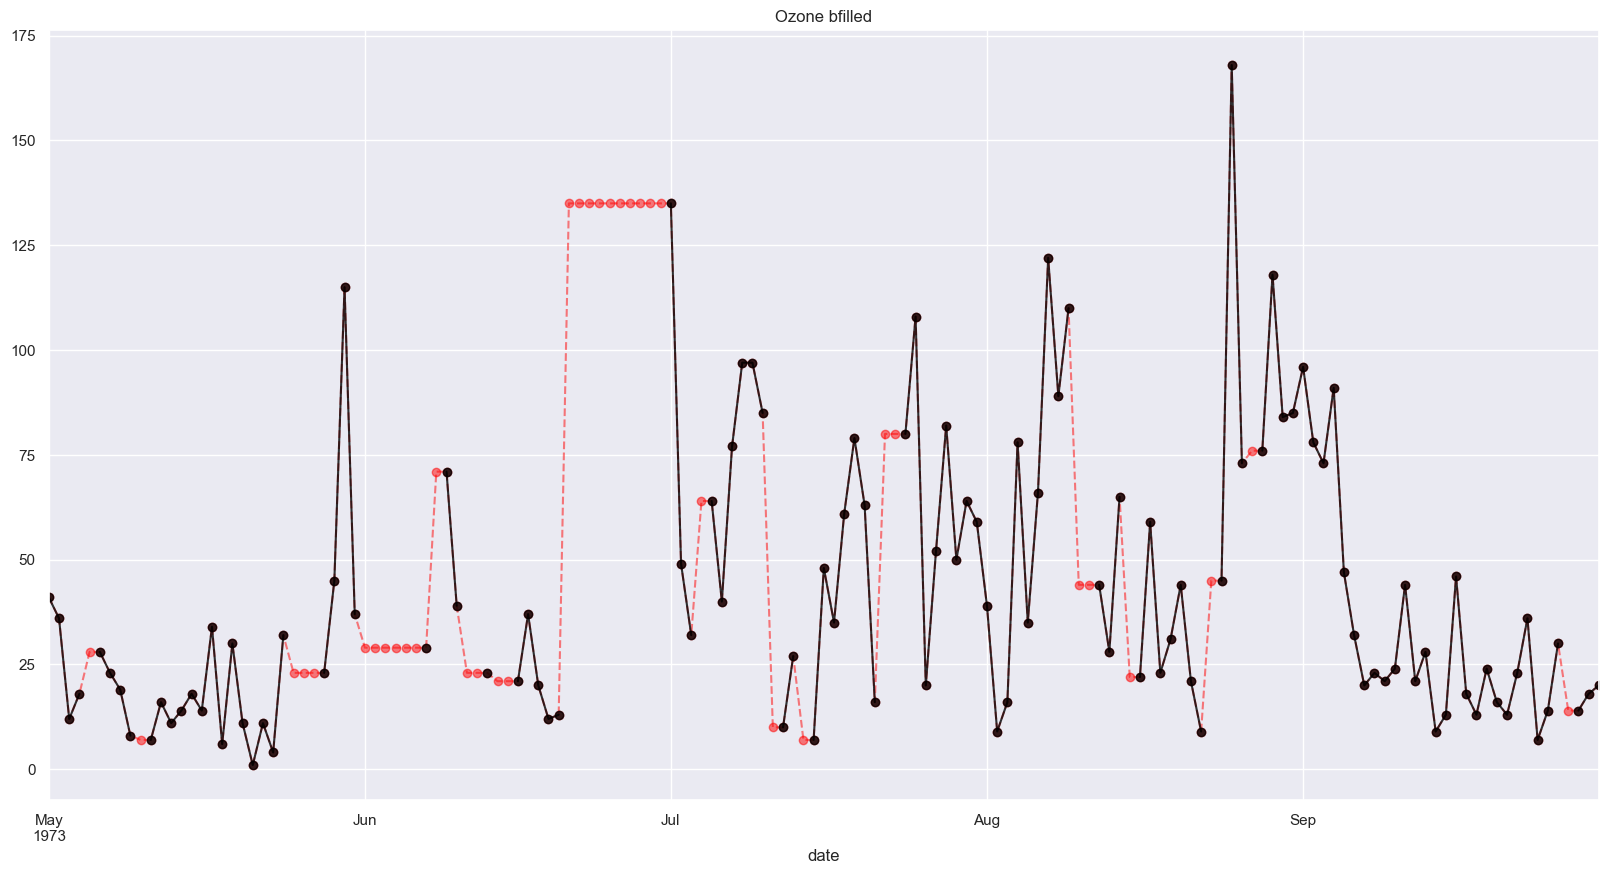

In [116]:
plt.figure(figsize=(20, 10))

(
    airquality_df
    .pipe(
        lambda df: (
            df.ozone.bfill().plot(marker='o', color='red', linestyle='--', alpha=0.5),
            df.ozone.plot(marker='o', alpha=.8, color='black')
        )
    )
)

plt.title('Ozone bfilled')

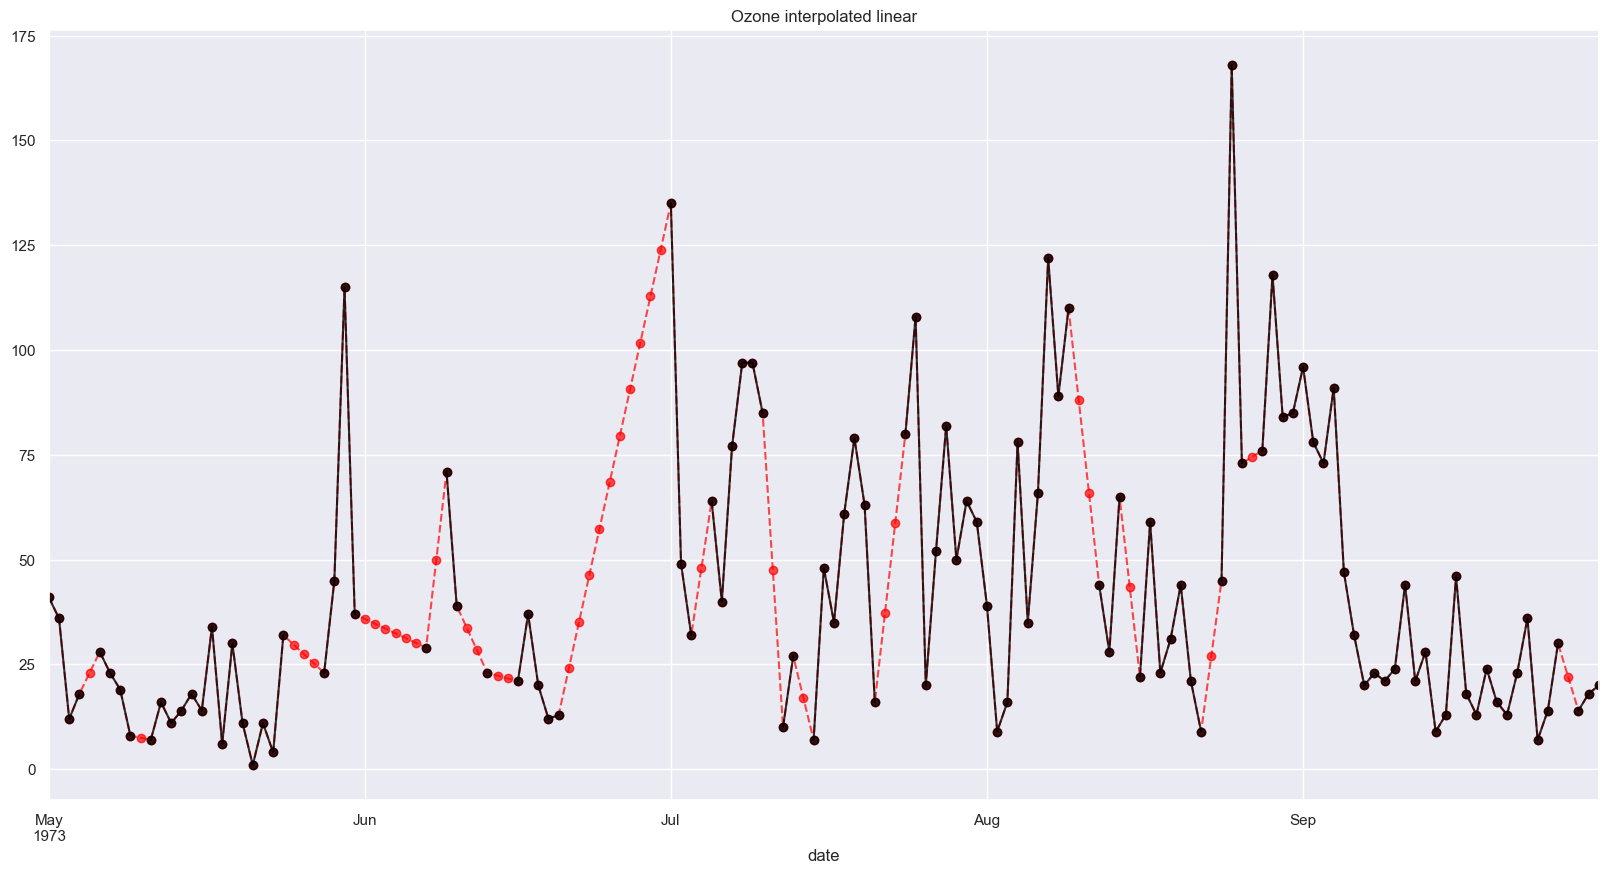

In [117]:
plt.figure(figsize=(20, 10))

(
    airquality_df
    .pipe(
        lambda df: (
            df.ozone.interpolate(method = 'linear').plot(marker='o', color='red', linestyle='--', alpha=.7),
            df.ozone.plot(marker='o', alpha=.8, color='black')
        )
    )
)

plt.title('Ozone interpolated linear')

plt.show()

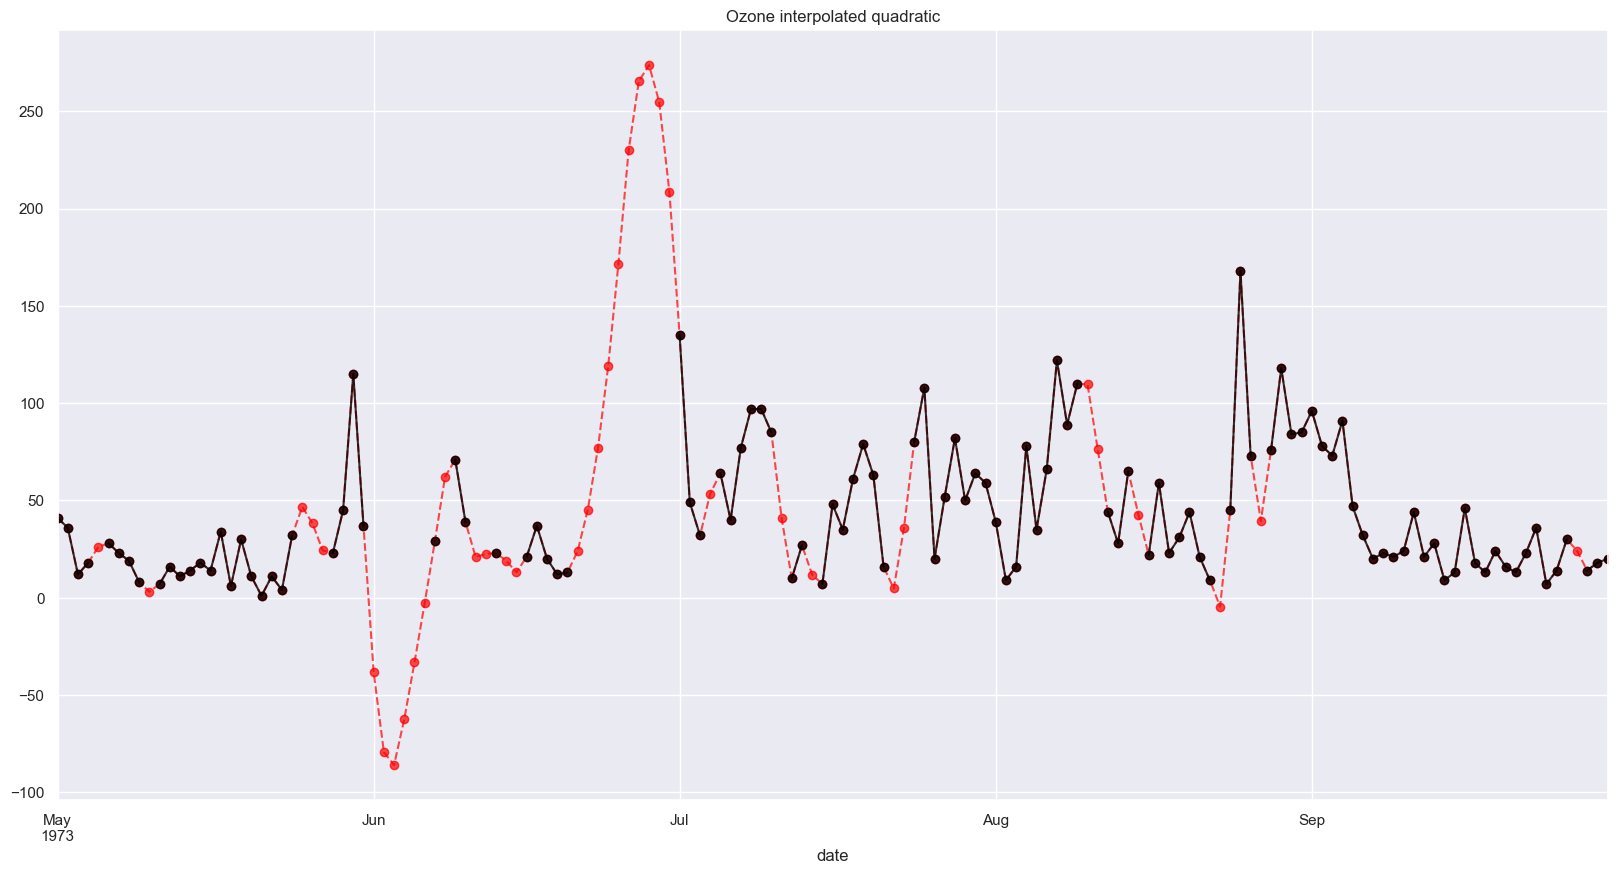

In [118]:
plt.figure(figsize=(20, 10))

(
    airquality_df
    .pipe(
        lambda df: (
            df.ozone.interpolate(method='quadratic').plot(
                marker='o', color='red', linestyle='--', alpha=.7),
            df.ozone.plot(marker='o', alpha=.8, color='black')
        )
    )
)

plt.title('Ozone interpolated quadratic')

plt.show()


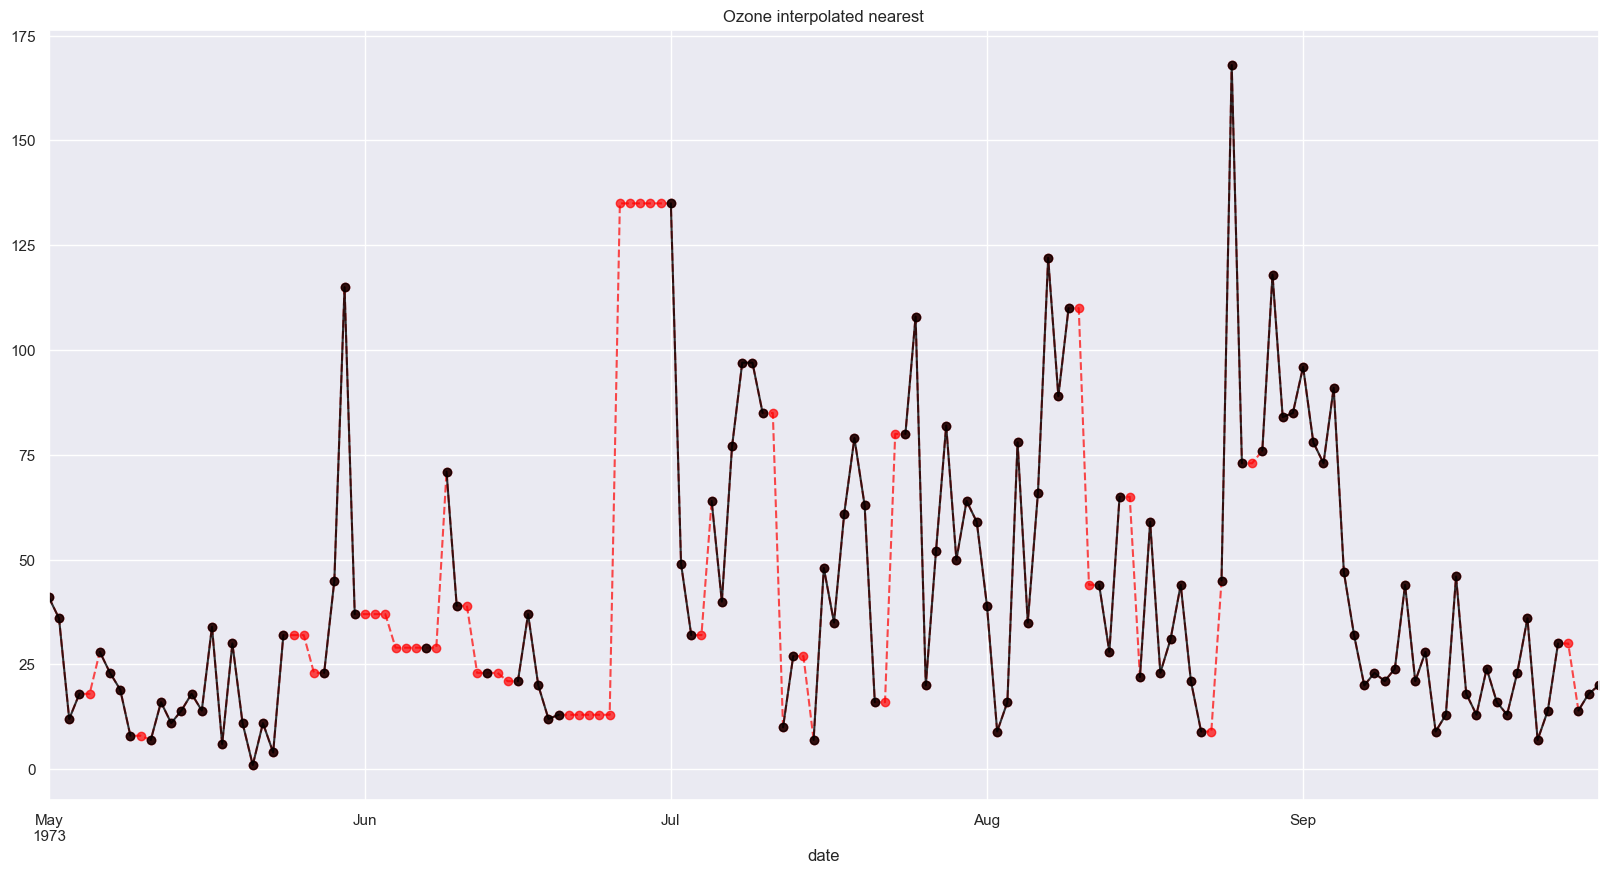

In [120]:
plt.figure(figsize=(20, 10))

(
    airquality_df
    .pipe(
        lambda df: (
            df.ozone.interpolate(method='nearest').plot(
                marker='o', color='red', linestyle='--', alpha=.7),
            df.ozone.plot(marker='o', alpha=.8, color='black')
        )
    )
)

plt.title('Ozone interpolated nearest')

plt.show()


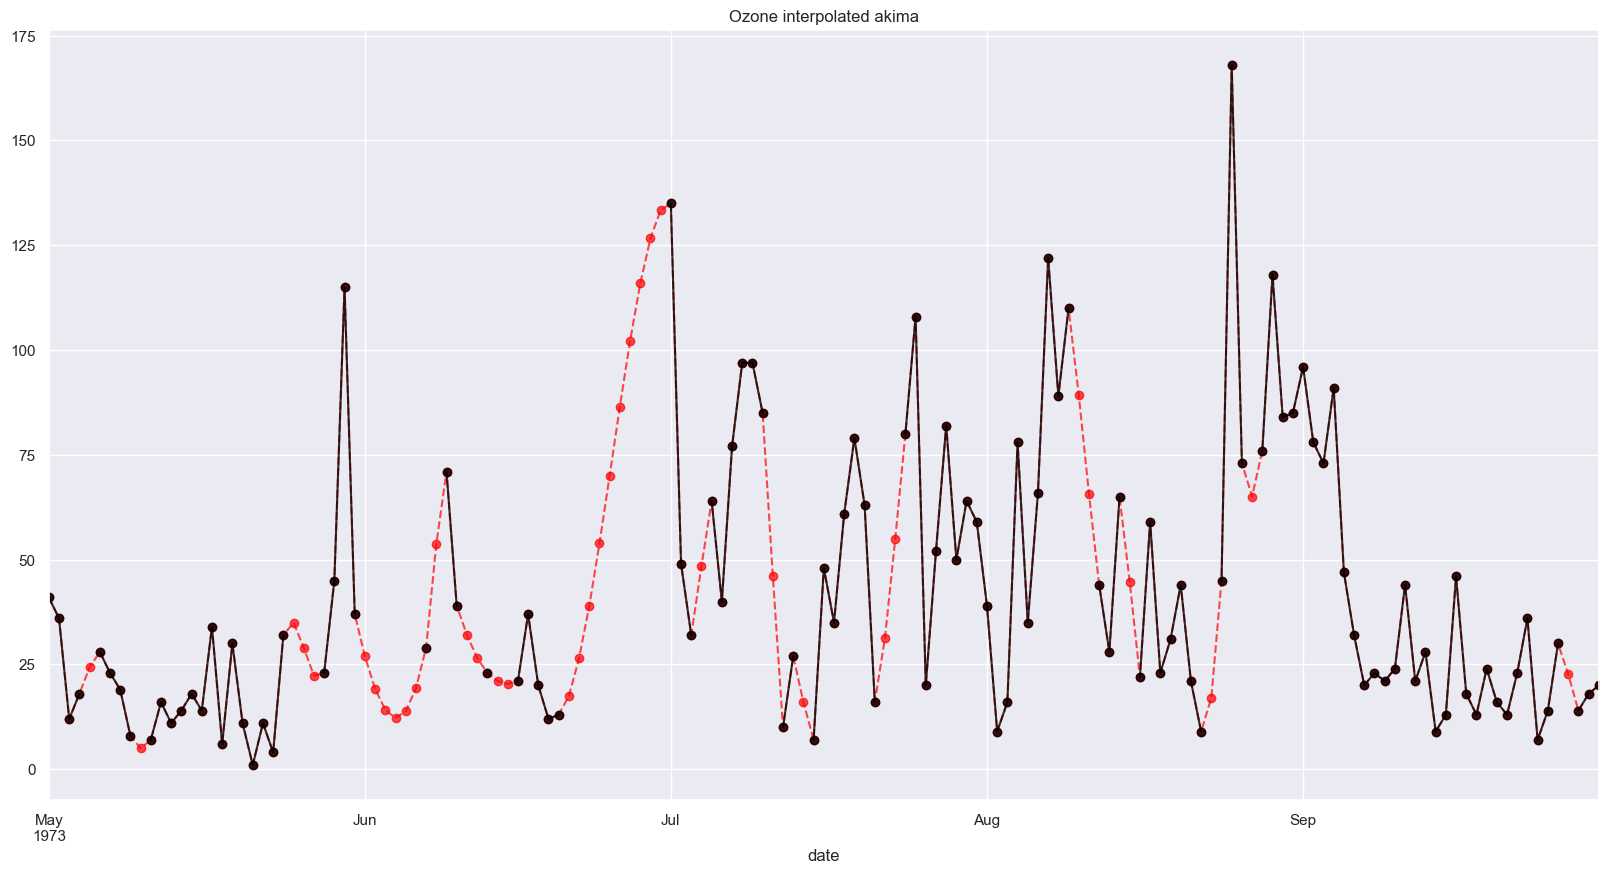

In [122]:
plt.figure(figsize=(20, 10))

(
    airquality_df
    .pipe(
        lambda df: (
            df.ozone.interpolate(method='akima').plot(
                marker='o', color='red', linestyle='--', alpha=.7),
            df.ozone.plot(marker='o', alpha=.8, color='black')
        )
    )
)

plt.title('Ozone interpolated akima')

plt.show()


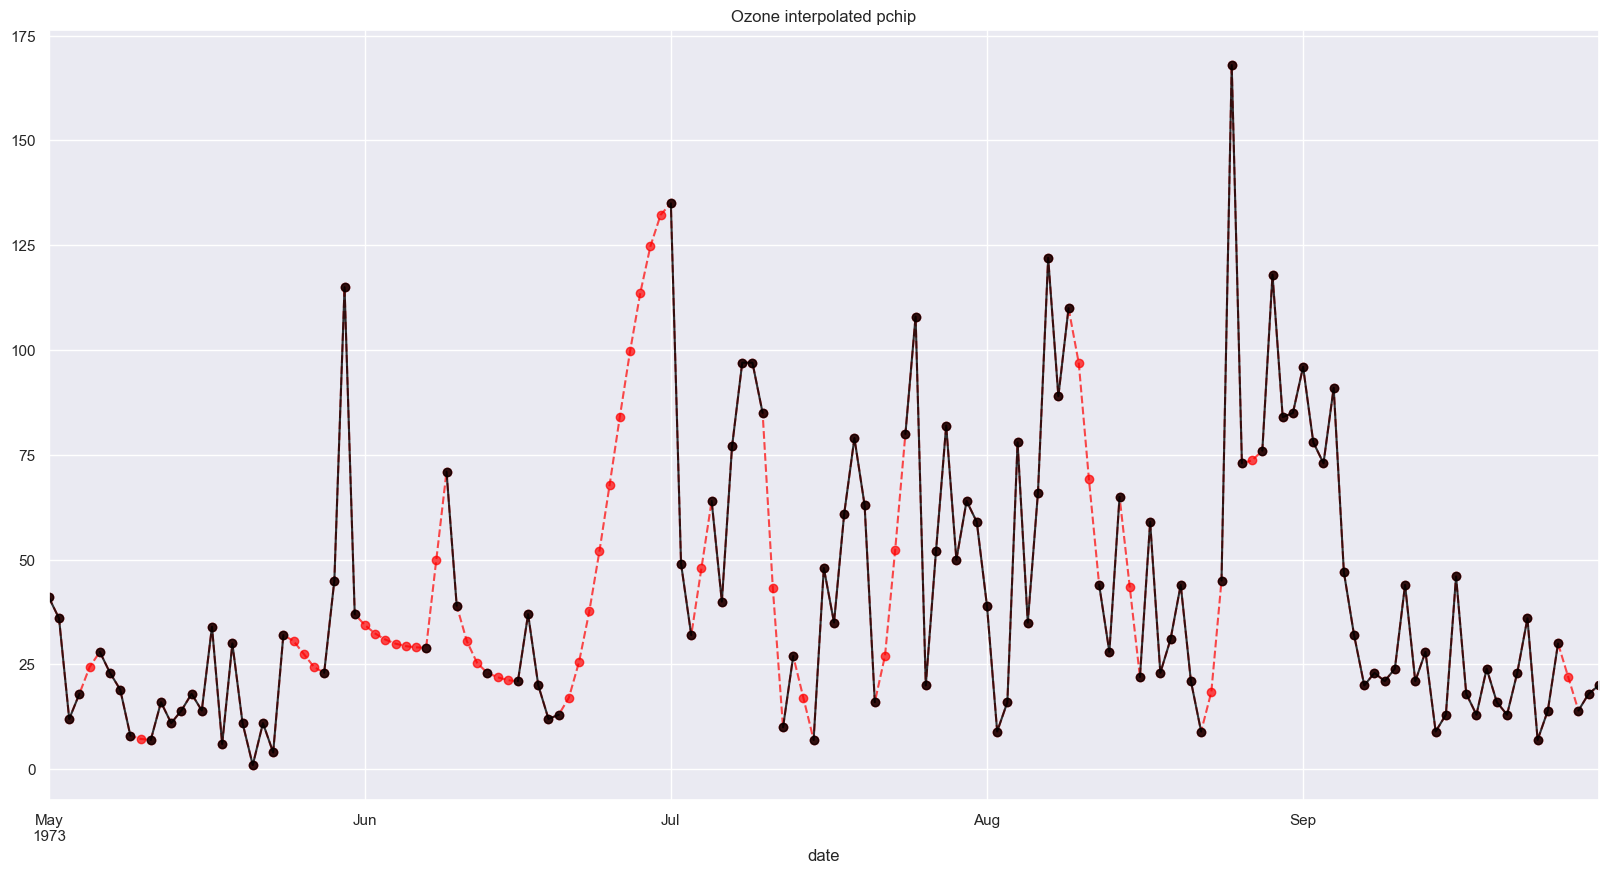

In [123]:
plt.figure(figsize=(20, 10))

(
    airquality_df
    .pipe(
        lambda df: (
            df.ozone.interpolate(method='pchip').plot(
                marker='o', color='red', linestyle='--', alpha=.7),
            df.ozone.plot(marker='o', alpha=.8, color='black')
        )
    )
)

plt.title('Ozone interpolated pchip')
plt.show()


In [125]:
airquality_df['ozone'] = airquality_df.ozone.interpolate(method='akima')
airquality_df.head()

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0000,190.0,7.4,67,5,1,1973
1973-05-02,36.0000,118.0,8.0,72,5,2,1973
1973-05-03,12.0000,149.0,12.6,74,5,3,1973
1973-05-04,18.0000,313.0,11.5,62,5,4,1973
1973-05-05,24.3125,NaN,14.3,56,5,5,1973


## Imputación por algoritmo de vecinos más cercanos (KNN)

!['ventajas y contras'](src/img/imputacion-knn.png)

**Euclidiana**: Útil para variables numéricas (continuas)

**Manhattan**: Útil paa variables tipo factor (categóricas)

**Hamming**: Útil para variables categóricas (binarias)

**Gower**: Útil para conjuntos de datos con variables mixtas (numéricas y categóricas)

Euclidiana formula: $$\sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}$$

Manhattan formula: $$\sum_{i=1}^{n} |x_i - y_i|$$

Hamming formula: $$\sum_{i=1}^{n} |x_i - y_i|$$

Gower formula: $$\sum_{i=1}^{n} \frac{|x_i - y_i|}{\max(x_i) - \min(x_i)}$$

In [127]:
knn_imputer = sklearn.impute.KNNImputer()

nhanes_df_knn = nhanes_transformed_df.copy()

nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_df_knn).round() # iloc[:, :] para que no me de un warning
nhanes_df_knn

,general_health_condition,gender,height,weight,cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,69.0,130.0,189.0,100.0,0.0,13.0
93709.0,2.0,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


<AxesSubplot: xlabel='height', ylabel='weight'>

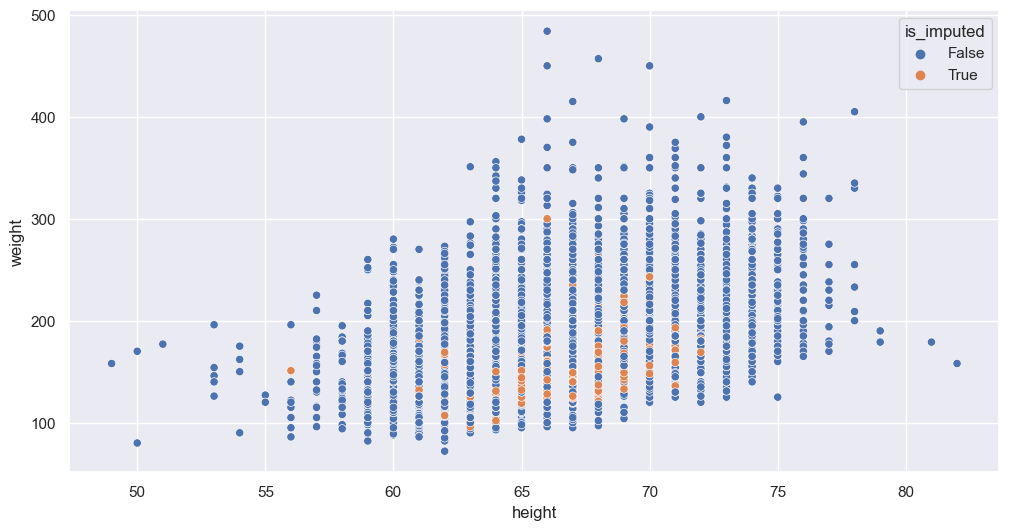

In [131]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(
        x='height',
        y='weight',
    )
)

#### Modo chatgpt

In [211]:
(
    nhanes_transformed_df
    .isna()
    .sum()
)

general_health_condition    1360
gender                         0
height                      1669
weight                      1604
cholesterol                  592
pulse                        587
diabetes                       0
age                            0
dtype: int64

In [190]:
imputer_knn = sklearn.impute.KNNImputer()
df_imputed_knn = pd.DataFrame(imputer_knn.fit_transform(nhanes_transformed_df), columns=nhanes_transformed_df.columns).round()

df_imputed_knn

,general_health_condition,gender,height,weight,cholesterol,pulse,diabetes,age
0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
1,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
2,2.0,1.0,69.0,130.0,189.0,100.0,0.0,13.0
3,2.0,0.0,62.0,200.0,176.0,74.0,0.0,75.0
4,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
7152,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
7153,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
7154,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0
7155,4.0,0.0,71.0,159.0,150.0,74.0,0.0,14.0


In [194]:
df_imputed_knn.isna().any()

general_health_condition        False
gender                          False
height                          False
weight                          False
cholesterol                     False
pulse                           False
diabetes                        False
age                             False
general_health_condition_imp     True
dtype: bool

In [209]:
df_imputed_knn['general_health_condition_imp'] = nhanes_transformed_df.general_health_condition.isna().any()

In [210]:
df_imputed_knn.general_health_condition_imp.value_counts()

True    7157
Name: general_health_condition_imp, dtype: int64

## Imputación basada en modelos

!['ventajas y contras'](src/img/imputacion-modelos.png)

In [147]:
nhanes_model_df = (
    nhanes_df[['height', 'weight', 'gender', 'age']]
    .sort_values(
        by='height',
    )
    .transform_column( # janitor 
        column_name='weight',
        function=lambda x: x.ffill(),
        elementwise=False # para que no se aplique a cada elemento de la columna
    )
    .missing.bind_shadow_matrix(True, False, suffix="_imp", only_missing=False)

)

nhanes_model_df

,height,weight,gender,age,height_imp,weight_imp,gender_imp,age_imp
SEQN,,,,,,,,
94940.0,49.0,158.0,Female,80.0,False,False,False,False
96508.0,50.0,170.0,Female,46.0,False,False,False,False
97877.0,50.0,80.0,Female,29.0,False,False,False,False
102379.0,51.0,177.0,Female,71.0,False,False,False,False
93816.0,53.0,146.0,Female,80.0,False,False,False,False
...,...,...,...,...,...,...,...,...
102915.0,NaN,107.0,Female,14.0,True,False,False,False
102926.0,NaN,107.0,Female,15.0,True,False,False,False
102941.0,NaN,107.0,Female,14.0,True,False,False,False


In [148]:
height_ols = (
    nhanes_model_df
    .pipe(
        lambda df: smf.ols(
            formula='height ~ weight + gender + age',
            data=df
        )
    )
    .fit()
)

In [149]:
ols_imputed_values = (
    nhanes_model_df
    .pipe(
        lambda df: df[df.height.isna()]
    )
    .pipe(
        lambda df: height_ols.predict(df).round()
    )
)

ols_imputed_values

SEQN
93707.0     69.0
93719.0     64.0
93733.0     64.0
93736.0     69.0
93737.0     69.0
            ... 
102915.0    63.0
102926.0    63.0
102941.0    63.0
102945.0    68.0
102955.0    63.0
Length: 1669, dtype: float64

In [150]:
nhanes_model_df.loc[nhanes_model_df.height.isna(), ['height']] = ols_imputed_values

<AxesSubplot: xlabel='height', ylabel='weight'>

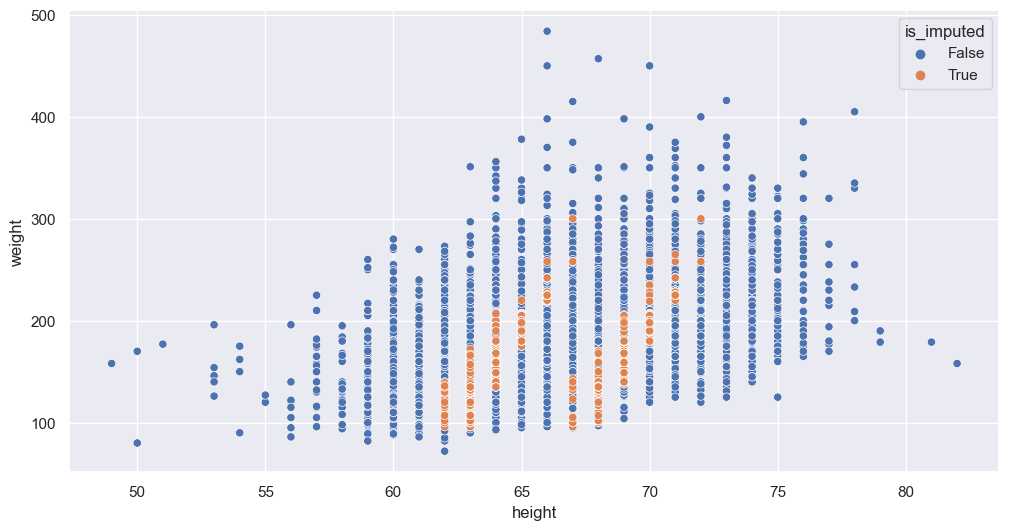

In [151]:
(
    nhanes_model_df
    .missing.scatter_imputation_plot(
        x='height',
        y='weight',
    )
)

## Imputaciones Múltiples por Ecuaciones Encadenadas (MICE)

![MICE](src/img/imputacion-mice.png)

In [213]:
mice_imputer = sklearn.impute.IterativeImputer(
    estimator=BayesianRidge(),
    initial_strategy='mean',
    imputation_order='ascending',
)

nhanes_mice_df = nhanes_transformed_df.copy()
nhanes_mice_df.iloc[:, :] = mice_imputer.fit_transform(nhanes_transformed_df).round()

In [214]:
nhanes_mice_df

,general_health_condition,gender,height,weight,cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,70.0,200.0,189.0,100.0,0.0,13.0
93709.0,2.0,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


<AxesSubplot: xlabel='height', ylabel='weight'>

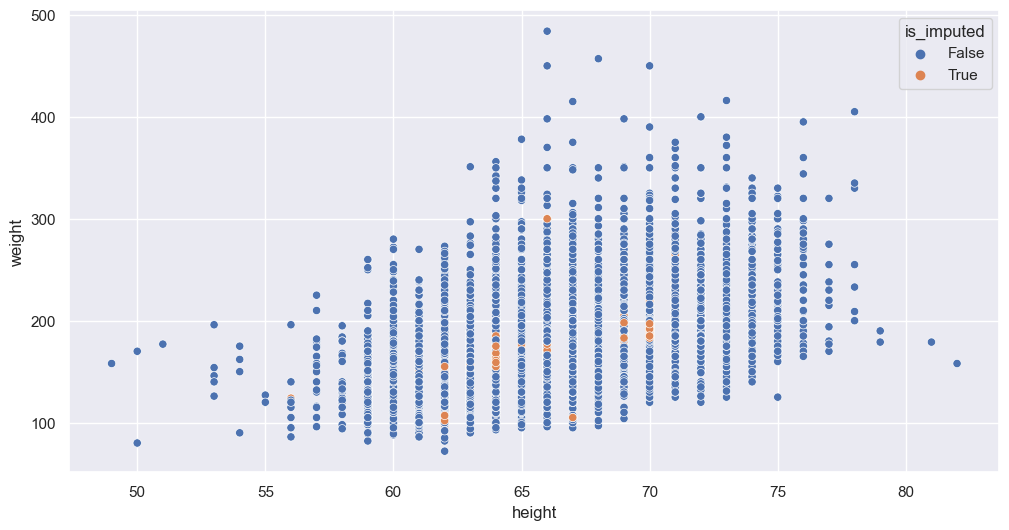

In [215]:
pd.concat(
    [
        nhanes_mice_df,
        nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
    ],
    axis=1
).missing.scatter_imputation_plot(
    x='height',
    y='weight',
)


## Transformación inversa de los datos

In [217]:
nhanes_imputed_df = nhanes_mice_df.copy()

In [221]:
nhanes_imputed_df[categorical_columns] = (
    categorical_transformer
    .named_transformers_
    .ordinalencoder
    .inverse_transform(
        X = nhanes_mice_df[categorical_columns]
    )
)

nhanes_imputed_df

,general_health_condition,gender,height,weight,cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,Good,Female,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,Very good,Male,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,Good,Male,70.0,200.0,189.0,100.0,0.0,13.0
93709.0,Good,Female,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,Very good,Male,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,Excellent,Male,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,Fair or,Male,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,Good,Female,66.0,150.0,172.0,78.0,0.0,41.0


In [222]:
nhanes_df.general_health_condition.value_counts()

Good         2383
Very good    1503
Fair or      1130
Excellent     612
Poor?         169
Name: general_health_condition, dtype: int64

In [223]:
nhanes_imputed_df.general_health_condition.value_counts()

Good         3743
Very good    1503
Fair or      1130
Excellent     612
Poor?         169
Name: general_health_condition, dtype: int64

In [224]:
nhanes_imputed_df.missing.number_missing()

0

## Continúa aprendiendo sobre el manejo de valores faltantes

<div class="alert alert-success">
    <b style="font-size: 1.5em;">✅ ¡Felicidades por terminar el curso!</b>
    <p>
    ¡Tu progreso es increíble! ¡Ahora eres capaz de llevar tus análisis al siguiente nivel! La barrera de los valores faltantes ya no es una limitante extrema para tu trabajo. Tú puedes explorar valores faltantes, eliminarlos e imputarlos siendo consciente de las ventajas y desventajas de cada método elegido. ¡Fantástico!
    </p>
    <p>
    <b>¿Cómo puedo continuar mi aprendizaje en el análisis de valores faltantes?</b>
    Poner en práctica lo aprendido es una excelente opción. Por lo tanto, te recomiendo repetir este curso utilizando la totalidad de los datos del <i>National Health and Nutrition Examination Survey</i>. Con este proyecto, serás capaz de explorar y analizar una cantidad de valores faltantes variadas. Podrás probar distintos algoritmos y estrategias. 
    </p>
    <p>
    De tal forma de que, una vez consigas tu conjunto de datos final, puedas proceder a la exploración definitiva del conjunto de datos para extraer ideas y respuestas a preguntas de tu interés. Incluso, y por qué no, podrías explorar la posibilidad de crear modelos predictivos para la diabetes. Las opciones son ilimitadas. Bienvenido al mundo de la Ciencia de Datos.
    </p>
    <p>
    Con mucha alegría por tu logro,
    Jesús Vélez Santiago
    </p>
</div>

## Información de sesión

In [216]:
session_info.show()

c:\Users\erik1\AppData\Local\Programs\Python\Python311\Lib\site-packages\session_info\main.py:213: DeprecationWarning: Accessing jsonschema.__version__ is deprecated and will be removed in a future release. Use importlib.metadata directly to query for jsonschema's version.
  mod_version = _find_version(mod.__version__)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bdf84ff9-f66c-44c7-a67c-ca1115a2b683' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>